In [2]:
import pandas as pd
import numpy as np
import time

from collections import Counter
import gensim
from gensim.models import CoherenceModel

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder


# Model
- ETM

# Step 1: Load dataset

In [3]:
# News Groups dataset
newsgroups_data = pd.read_csv('data/fetch_7newsgroups.csv')
newsgroups_data.dropna(inplace=True,subset='label')
label_encoder_newsgroups = LabelEncoder()
newsgroups_data['topic'] = label_encoder_newsgroups.fit_transform(newsgroups_data['label'])

newsgroup_text = newsgroups_data['text'].tolist()
newsgroup_labels = newsgroups_data['topic'].tolist()


# BBC News dataset
bbc_news = pd.read_csv("data/bbc-news-data.csv",sep="\t")  # Load the BBC dataset

label_encoder_bbc = LabelEncoder()
bbc_news['topic'] = label_encoder_bbc.fit_transform(bbc_news['category'])

bbc_texts = bbc_news.apply(lambda r:r.title+r.content,axis=1).to_list()
bbc_labels = bbc_news['topic'].to_list()


In [4]:
import re
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


def preprocess_text(text,preprocess=True):
    if not preprocess:
        return text
    # Convert text to lowercase
    text = text.lower()

    # Replace email addresses with 'EMAIL'
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', 'EMAIL', text)

    # Replace URLs with 'HTTP'
    text = re.sub(r'https?://\S+|www\.\S+', 'HTTP', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = ' '.join(text.split())# drop white spaces


    #stamming

    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    #remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset_name = 'newsgroup'

if dataset_name == 'bbc':
    documents = bbc_texts
    true_labels = bbc_labels
    test_ratio = 0.2
    do_preprocess = True
elif dataset_name == 'newsgroup':
    documents = newsgroup_text
    true_labels = newsgroup_labels
    test_ratio = 0.05
    do_preprocess = True


In [6]:
from tqdm import tqdm
documents = [preprocess_text(doc,do_preprocess) for doc in tqdm(documents)]


100%|██████████| 17849/17849 [01:26<00:00, 205.70it/s]


In [7]:
# Step 2: Split the dataset 80-20 into train and test sets
train_docs, test_docs, train_labels, test_labels = train_test_split(documents, true_labels, test_size=test_ratio, random_state=42)

df = pd.DataFrame({'text':train_docs,'label':train_labels,'div':'train'})
df2 = pd.DataFrame({'text':test_docs,'label':test_labels,'div':'test'})

df = pd.concat([df,df2],ignore_index=True)
del df2

df['tok'] = df['text'].apply(lambda x: x.split())


In [8]:
dictionary = gensim.corpora.Dictionary(df[df['div']=='train']['tok'].to_numpy())
bow_corpus = [dictionary.doc2bow(doc) for doc in df.tok]


# ETM

In [9]:
%%capture
! pip install fasttext

In [58]:
del model

In [10]:
import fasttext
import fasttext.util
from sklearn.cluster import KMeans

# ft_model_path = fasttext.util.download_model('en', if_exists='ignore') # changed to download_model and saving the path to ft_model_path

# load the model from the downloaded path
model = fasttext.load_model('cc.en.300.bin')

In [11]:
%%time
start_time = time.time()

vectors = [model.get_sentence_vector(x) for x in df[df['div']=='train']['text']]

end_time = time.time()
training_time = end_time - start_time


CPU times: user 12.8 s, sys: 102 ms, total: 12.9 s
Wall time: 23.6 s


In [12]:
vectors[0].shape

(300,)

In [13]:
TOPICS = 7

Best NMI: 0.336744078909426
Best parameters: {'n_init': 6, 'max_iter': 100, 'init': 'random'}


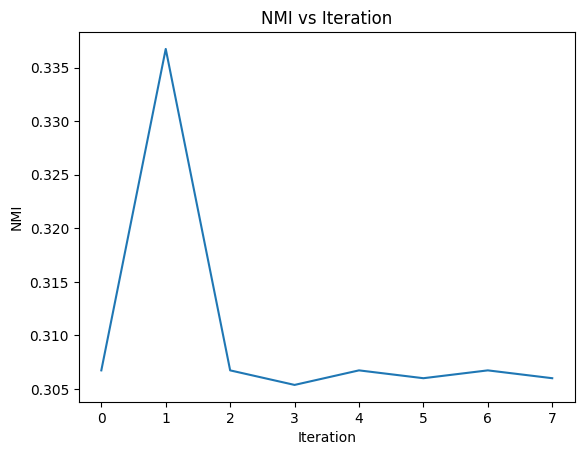

In [14]:
import matplotlib.pyplot as plt

n_init_list = [6,10]
max_iter_list = [100, 400]
init_list = ['k-means++','random']


best_nmi = 0
best_params = {}
nmis = []
for n_init in n_init_list:
  for max_iter in max_iter_list:
    for init in init_list:
      kmeans = KMeans(n_clusters=TOPICS, n_init=n_init, max_iter=max_iter, init=init, random_state=42)
      kmeans.fit(vectors)
      predicted_labels = kmeans.labels_
      nmi = normalized_mutual_info_score(train_labels, predicted_labels)
      nmis.append(nmi)
      if nmi > best_nmi:
        best_nmi = nmi
        best_params = {'n_init': n_init, 'max_iter': max_iter, 'init': init, }

print(f"Best NMI: {best_nmi}")
print(f"Best parameters: {best_params}")


# plot nmis
plt.plot(nmis)
plt.xlabel('Iteration')
plt.ylabel('NMI')
plt.title('NMI vs Iteration')
plt.show()

# Now you can use the best parameters to train your final KMeans model


In [15]:
%%time
start_time = time.time()

kmeans = KMeans(n_clusters=TOPICS, **best_params, random_state=42)
kmeans.fit(vectors)
topics = kmeans.predict(vectors)

end_time = time.time()
training_time = training_time + end_time - start_time

CPU times: user 9.14 s, sys: 44.7 ms, total: 9.19 s
Wall time: 9.27 s


In [16]:
%%time
start_time = time.time()

test_vectors = [model.get_sentence_vector(x) for x in df[df['div']=='test']['text']]
test_topics = kmeans.predict(test_vectors)

end_time = time.time()
testing_time = end_time - start_time

CPU times: user 485 ms, sys: 8.3 ms, total: 494 ms
Wall time: 489 ms


In [17]:
# Step 5: Evaluate the model using Purity and NMI on test data

# 5.1 Helper function to compute purity
def calculate_purity(topics, true_labels):
    df = pd.DataFrame({'Topic': topics, 'True Label': true_labels})
    majority_count = 0
    for topic, group in df.groupby('Topic'):
        majority_class = group['True Label'].mode()[0]
        majority_count += (group['True Label'] == majority_class).sum()
    purity = majority_count / len(df)
    return purity

# Step 6: Compute Purity and NMI for test data
test_purity = calculate_purity(test_topics, test_labels)
test_nmi = normalized_mutual_info_score(test_labels, test_topics)

# Step 7: Output results
print(f"Test Purity: {test_purity}")
print(f"Test NMI: {test_nmi}")

Test Purity: 0.6024636058230683
Test NMI: 0.3443756570704122


In [18]:
from scipy import stats


# Step 1: Create a DataFrame for training data
train_df = pd.DataFrame({
    'topic': topics,
    'label': train_labels
})

# Step 2: Group by 'topic' and count how many of each label there are for each topic in the training data
train_topic_label_counts = train_df.groupby(['topic', 'label']).size().unstack(fill_value=0)

# Step 3: Assign the mode (most frequent label) for each topic in the training data
topic_to_mode_label = train_df.groupby('topic')['label'].agg(lambda x: stats.mode(x)[0])

# Step 4: Map the predicted test topics to actual labels using the mapping from training data
mapped_test_labels = [topic_to_mode_label.get(topic, None) for topic in test_topics]

# Create a DataFrame to combine mapped test labels and actual test labels
test_results_df = pd.DataFrame({
    'predicted_label': mapped_test_labels,
    'true_label': test_labels
})



In [19]:
from sklearn.metrics import classification_report
print(classification_report(test_results_df.true_label,test_results_df.predicted_label,digits=3))

              precision    recall  f1-score   support

           0      0.413     0.452     0.432        42
           1      0.465     0.418     0.440       141
           2      0.561     0.755     0.643        49
           3      0.490     0.479     0.485       213
           4      0.750     0.826     0.786       109
           5      0.858     0.669     0.752       281
           6      0.355     0.655     0.461        58

    accuracy                          0.597       893
   macro avg      0.556     0.608     0.571       893
weighted avg      0.625     0.597     0.603       893



In [20]:
# Generate classification report
report = classification_report(test_results_df.predicted_label,test_results_df.true_label,digits=3, output_dict=True)

report['purity'] = test_purity
report['nmi'] = test_nmi
report['training_time'] = training_time
report['testing_time'] = testing_time
# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Specify the file path and sheet name
file_path = 'Topic_modeling_classification_report.xlsx'
sheet_name = f'ETM_{dataset_name}_{TOPICS}'

# Write the DataFrame to an Excel sheet
with pd.ExcelWriter(file_path, engine='openpyxl',  mode='a', if_sheet_exists='new') as writer:
    report_df.to_excel(writer, sheet_name=sheet_name)

print(f"Classification report saved to '{file_path}' in sheet '{sheet_name}'")


Classification report saved to 'Topic_modeling_classification_report.xlsx' in sheet 'ETM_newsgroup_15'
